In [1]:
import os
import numpy as np
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import skopt
from skopt.space import *
from skopt.utils import use_named_args
from skopt import gp_minimize

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
torch.cuda.is_available()

True

In [4]:
cd = torch.cuda.current_device()
torch.cuda.get_device_name(cd)

'NVIDIA GeForce RTX 3060'

## Load the interpolated spectrum files

In [7]:
dr16qsnr10_dataset_np = np.load('dr16qsnr10_dataset_vae_eval.npy')
dr16qsnr10_errterm_np = np.load('dr16qsnr10_errterm_vae_eval.npy')

normalize dataset

In [8]:
# get max norms of each spectrum
norms = np.max(dr16qsnr10_dataset_np, axis=1)[:,None]
# normalize each of the spectra
dr16qsnr10_dataset_np = dr16qsnr10_dataset_np/norms

normalize error terms

In [9]:
dr16qsnr10_errterm_np = dr16qsnr10_errterm_np/norms # normalize all the flux errors 
ivar = 1/dr16qsnr10_errterm_np**2 # inverse variance

eps = 1./(2e6) # weight cap
data_weights = ivar/(1 + eps*ivar)

subsampled to 1500 elements each spectrum

In [10]:
dr16qsnr10_dataset_np.shape

(21771, 1500)

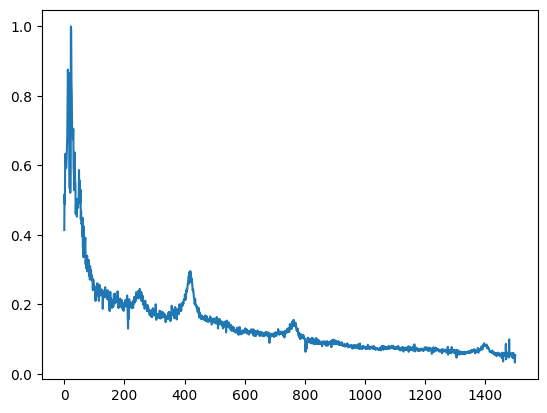

In [11]:
plt.plot(dr16qsnr10_dataset_np[245, :])

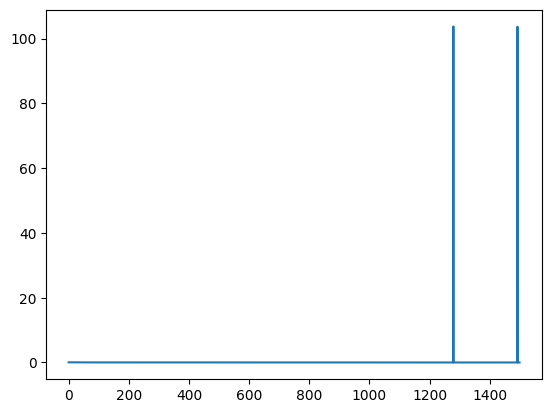

In [12]:
plt.plot(dr16qsnr10_errterm_np[245, :])

## VAE implementation
Import code file `InfoVAE_2.py` \
adapted from: https://github.com/stephenportillo/SDSS-VAE/blob/master/InfoVAE.py

In [13]:
from torch import optim

In [14]:
from InfoVAE_2 import *

#### dataset train/valid setup

In [15]:
spec = dr16qsnr10_dataset_np
weights = data_weights

In [16]:
# train test split - number in each set
trainfrac = 0.75
ntrain = int(spec.shape[0] * trainfrac)
nvalid = spec.shape[0] - ntrain
# number of feature (number of pixel in each spectrum)
nfeat = spec.shape[1]

In [17]:
# splitting the dataset
# make validation set deterministic
np.random.seed(645847)
permutation = np.random.permutation(spec.shape[0])

# indices of train set
trainidx = permutation[0:ntrain]
# validation set indices
valididx = permutation[-1-nvalid:-1]
# train and test sets
trainspec = spec[trainidx,:]
validspec = spec[valididx,:]
trainweig = weights[trainidx,:]
validweig = weights[valididx,:]
# np.savez(tag+'/datasplit.npz', trainidx=trainidx, valididx=valididx)

In [18]:
trainspec.shape

(16328, 1500)

In [19]:
batch_size=64

In [20]:
# torch dataloader for training in batches
# train set
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(trainspec, dtype=torch.float32), torch.tensor(trainweig, dtype=torch.float32)),
    batch_size=batch_size,
    shuffle=True)
# valid set
valdloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(validspec, dtype=torch.float32), torch.tensor(validweig, dtype=torch.float32)),
    batch_size=nvalid)

#### utility setup

In [21]:
def train(model, optimizer, epoch, records): #model, optimizer, epoch, min_valid_loss, badepochs
    model.train()
    train_loss = 0
    train_logL = 0
    train_KLD = 0
    train_MMD = 0
    for batch_idx, data in enumerate(dataloader):
        spectrum, weig = data
        
        optimizer.zero_grad()
        # logL here is the MSE
        loss, logL, KLD, MMD = model.loss(spectrum, weig, epoch)
        loss.backward()
        train_loss += loss.item()
        train_logL += logL.item()
        train_KLD += KLD.item()
        train_MMD += MMD.item()
        optimizer.step()
    train_loss /= len(dataloader.dataset)

    records['train_loss'].append(train_loss)
    records['train_MSE'].append(train_logL / len(dataloader.dataset))
    records['train_KLD'].append(train_KLD / len(dataloader.dataset))
    records['train_MMD'].append(train_MMD / len(dataloader.dataset))
    
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        valid_logL = 0
        valid_KLD = 0
        valid_MMD = 0

        for valddata in valdloader:
            spectrum, weig = valddata
            
            # logL here is the MSE
            loss, logL, KLD, MMD = model.loss(spectrum, weig, epoch)
            valid_loss += loss.item()
            valid_logL += logL.item()
            valid_KLD += KLD.item()
            valid_MMD += MMD.item()
        
        valid_loss /= len(valdloader.dataset)
        valid_logL /= -len(valdloader.dataset)
        valid_KLD  /= len(valdloader.dataset)
        valid_MMD  /= len(valdloader.dataset)
        
        records['valid_loss'].append(valid_loss)
        records['valid_MSE'].append(-valid_logL)
        records['valid_KLD'].append(valid_KLD)
        records['valid_MMD'].append(valid_MMD)
        
    return valid_loss, valid_logL, valid_KLD, valid_MMD

In [22]:
class EarlyStopper:
    def __init__(self, precision=1e-3, patience=10):
        self.precision = precision
        self.patience = patience
        self.badepochs = 0
        self.min_valid_loss = float('inf')
        
    def step(self, valid_loss):
        if valid_loss < self.min_valid_loss*(1-self.precision):
            self.badepochs = 0
            self.min_valid_loss = valid_loss
        else:
            self.badepochs += 1
        return not (self.badepochs == self.patience)

#### other parameters

In [23]:
# max number of epoches each try
epochs = 200
# number of tries, each with different configuration
n_config = 100
# print logs every this many epoches
log_interval = 1

We optimize the hyperparameters using `skopt`'s `gp_minimize`

In [24]:
# define the space of hyperparameters to search
search_space = list()
search_space.append(Real(2.0 ** -3, 2.0 ** 6, 'log-uniform', name='lambda'))
# search_space.append(Real(0.0, 0.9, 'uniform', name='alpha'))
# search_space.append(Integer(8, 256, 'log-uniform', base=2, name='layer_1'))
# search_space.append(Integer(8, 128, 'log-uniform', base=2, name='layer_2'))
# search_space.append(Integer(0, 2, 'uniform', name='pre_latent_depth'))
# search_space.append(Integer(0, 7, 'uniform', name='pre_latent_width'))

In [25]:
# arrays to record the results
results = {}

In [26]:
# the folder to store the saved neural networks in
tag = 'VAE_dr16qsnr10_hypersearch_2024-12-16e'

#### train with hyperparam optimization

Objective of this notebook: attempt to recreate the training of a 9 latent dimension VAE but fully record train/valid MSE value changes

In [27]:
# number of latent dimiensions is a hyperparameter independent from others
ncode = 9
# set it to the following values:
# ncode_vals = [12, 15]

In [28]:
params = {'lambda': 8.547600127202138}

In [29]:
records = {
    'train_loss': [], 'train_MSE': [], 'train_KLD': [], 'train_MMD': [],
    'valid_loss': [], 'valid_MSE': [], 'valid_KLD': [], 'valid_MMD': [],
}

In [30]:
# define the function used to evaluate a given configuration
# @use_named_args(search_space)
def evaluate_model(params, records):
    # unpack the hyperparameters
    lambd = params['lambda']
    # alpha = params['alpha']
    alpha = 0.0
    nhidden1 = 256
    nhidden2 = 128
    # pre_depth = params['pre_latent_depth']
    pre_depth = 0
    # pre_width = params['pre_latent_width']
    # the network topology (number of pre-depth layers is 1 hyperparam)
    nhidden = [nhidden1, nhidden2] + [ncode,] * pre_depth

    # these are not changed
    # dropout (not used?)
    dropout = 0   #0.9*np.random.uniform()
    dfac = 1./(1.-dropout)

	# create model with specific hyperparameters
    # print('config: alpha = %0.1f, lambda = %0.1f; hidden layers with %s, nodes' % (alpha, lambd, str(nhidden)))
    print('config: alpha = %0.1f, lambda = %0.1f; hidden layers with %s, nodes' % (alpha, lambd, str(nhidden)))

    # create model
    model = InfoVAE(alpha=alpha, lambd=lambd, nfeat=nfeat, nhidden=nhidden, ncode=ncode, dropout=dropout)

    # optimizer and auxilary components for the model
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=5)
    stopper = EarlyStopper(patience=10)

    # the metric we are optimizing on is validation loss
    res_valid_loss = None

    # train many epoches
    for epoch in range(1, epochs + 1):
        # train call
        valid_loss, valid_logL, valid_KLD, valid_MMD = train(model, optimizer, epoch, records)
        
        if epoch % log_interval == 0:
            print('====> Epoch: {} VALIDATION Loss: {:.2e} logL: {:.2e} KL: {:.2e} MMD: {:.2e}'.format(
                  epoch, valid_loss, valid_logL, valid_KLD, valid_MMD))

        # scheduler to update weights
        scheduler.step(valid_loss)
        # early stopper
        if (not stopper.step(valid_loss)) or (epoch == epochs):
            print('Stopping')
            print('====> Epoch: {} VALIDATION Loss: {:.2e} logL: {:.2e} KL: {:.2e} MMD: {:.2e}'.format(
                  epoch, valid_loss, valid_logL, valid_KLD, valid_MMD))
            model.MSE = -valid_logL
            model.KLD = valid_KLD
            model.MMD = valid_MMD
            # mdl_MSE[i] = model.MSE
            # mdl_KLD[i] = model.KLD
            # mdl_MMD[i] = model.MMD
            
            res_valid_loss = float(valid_loss)
            
            # save model
            torch.save(model, tag+'/VAE_%ifeat_lambd-%f_alpha-%f_nhidden-%s.pth' % (ncode, lambd, alpha, '-'.join([str(i) for i in nhidden])))
            break

	# minimize valid loss
    return res_valid_loss, model

In [31]:
res_valid_loss, res_model = evaluate_model(params, records)

config: alpha = 0.0, lambda = 8.5; hidden layers with [256, 128], nodes


C:\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


====> Epoch: 1 VALIDATION Loss: 4.76e+04 logL: -4.76e+04 KL: 7.64e-01 MMD: 3.77e-01
====> Epoch: 2 VALIDATION Loss: 3.21e+04 logL: -3.21e+04 KL: 4.01e+00 MMD: 1.66e+00
====> Epoch: 3 VALIDATION Loss: 2.31e+04 logL: -2.30e+04 KL: 7.61e+00 MMD: 2.75e+00
====> Epoch: 4 VALIDATION Loss: 1.94e+04 logL: -1.94e+04 KL: 1.00e+01 MMD: 3.51e+00
====> Epoch: 5 VALIDATION Loss: 1.78e+04 logL: -1.77e+04 KL: 1.18e+01 MMD: 3.88e+00
====> Epoch: 6 VALIDATION Loss: 1.70e+04 logL: -1.69e+04 KL: 1.31e+01 MMD: 4.25e+00
====> Epoch: 7 VALIDATION Loss: 1.63e+04 logL: -1.62e+04 KL: 1.42e+01 MMD: 4.17e+00
====> Epoch: 8 VALIDATION Loss: 1.55e+04 logL: -1.54e+04 KL: 1.52e+01 MMD: 4.38e+00
====> Epoch: 9 VALIDATION Loss: 1.49e+04 logL: -1.48e+04 KL: 1.61e+01 MMD: 4.41e+00
====> Epoch: 10 VALIDATION Loss: 1.30e+04 logL: -1.30e+04 KL: 1.70e+01 MMD: 4.45e+00
====> Epoch: 11 VALIDATION Loss: 1.28e+04 logL: -1.27e+04 KL: 1.80e+01 MMD: 4.55e+00
====> Epoch: 12 VALIDATION Loss: 1.24e+04 logL: -1.24e+04 KL: 1.87e+01 MMD

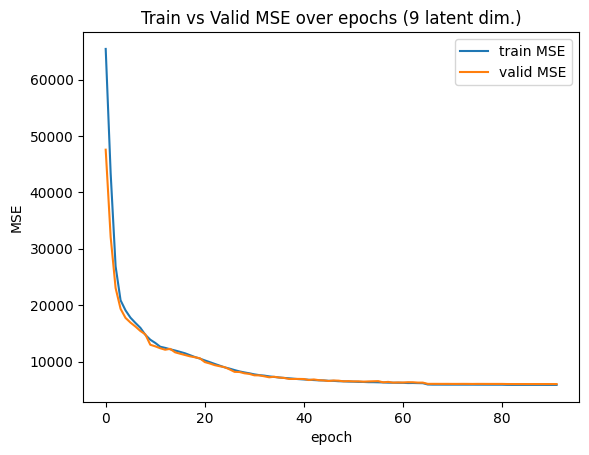

In [32]:
plt.plot(records['train_MSE'], label='train MSE')
plt.plot(records['valid_MSE'], label='valid MSE')
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Train vs Valid MSE over epochs (9 latent dim.)")

plt.legend()

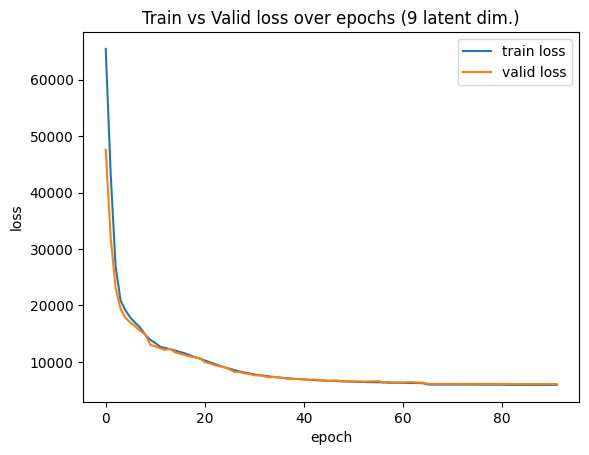

In [33]:
plt.plot(records['train_loss'], label='train loss')
plt.plot(records['valid_loss'], label='valid loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Valid loss over epochs (9 latent dim.)")

plt.legend()

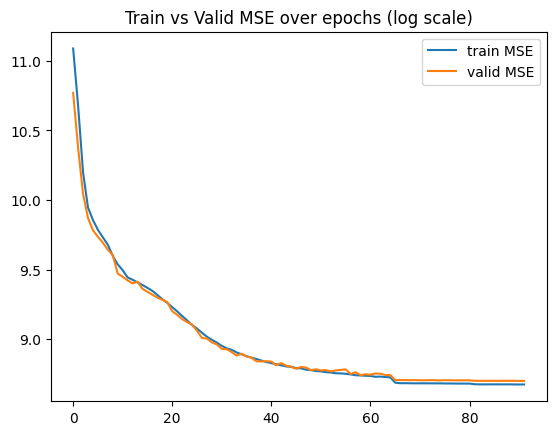

In [34]:
plt.plot(np.log(records['train_MSE']), label='train MSE')
plt.plot(np.log(records['valid_MSE']), label='valid MSE')
plt.title("Train vs Valid MSE over epochs (log scale)")

plt.legend()

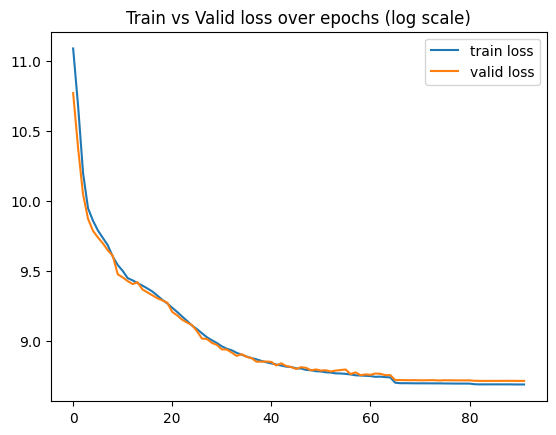

In [35]:
plt.plot(np.log(records['train_loss']), label='train loss')
plt.plot(np.log(records['valid_loss']), label='valid loss')
plt.title("Train vs Valid loss over epochs (log scale)")

plt.legend()

In [36]:
np.array(records['train_loss']) - np.array(records['train_MSE'])

array([ 2.14454082, 10.55558416, 24.38515702, 34.05098029, 39.80637651,
       43.12162342, 45.52732318, 47.54604437, 49.3541051 , 50.74874114,
       52.16431322, 53.18202867, 54.07763887, 54.37784189, 54.61763248,
       54.87649044, 55.36239177, 55.66699889, 56.00351462, 56.14793271,
       57.3239099 , 57.31125501, 57.47144954, 58.23718172, 58.55825643,
       58.70545899, 59.39024509, 60.25714288, 60.78425313, 62.05944711,
       62.38037731, 62.71513131, 63.66032276, 64.02404899, 64.53142464,
       65.08320351, 65.51256086, 66.20642215, 66.73727311, 67.40725958,
       67.88717019, 68.51199148, 69.30936792, 69.53388232, 70.29284435,
       70.72739313, 71.26982719, 71.72713954, 72.25419405, 72.62595772,
       73.06703879, 73.29060581, 73.84418063, 73.86286259, 74.1118444 ,
       74.3799254 , 74.52293606, 74.58608678, 74.70261303, 74.77737605,
       74.72158184, 74.80911457, 75.05964017, 74.8635669 , 74.65087257,
       74.69190697, 74.68449519, 74.76106827, 74.8001334 , 74.70